In [2]:
!pip install pystan==2.19.1.1
!pip install prophet

In [1]:
import os
import glob
import csv
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge

from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse

import random
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
import datetime

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

In [2]:
def interpolate_method(df,column_name,methode,direction,order,limit):
  df[column_name] = df[column_name].interpolate(method=methode,limit_direction = direction,order=order,limit=limit)
  return df

def clean_csv(df,time_variable,quantitative_variable):
  df = df[[time_variable, quantitative_variable]].copy()
  df.columns = ['ds','y']
  df['y'] = (df['y'].apply(pd.to_numeric, errors='coerce')).to_frame()
  df = df.drop_duplicates(subset=['ds'])
  df['ds'] = pd.to_datetime(df.ds, errors = 'coerce')
  df = df.dropna(subset=['ds'])
  df = df.sort_values(by=['ds'])
  pourcentage = ((len(df) - df['y'].count()) / len(df)) * 100
  if (pourcentage <= 2):
    df = df.dropna(subset=['y'])
  elif((pourcentage > 2) and (pourcentage < 25)):
    df = interpolate_method(df,'y',"polynomial",None,2,None)
  elif((pourcentage >= 25)):
    print("La base de donnée comporte un grand nombre de données manquantes pour être étudiée.")
  if(len(df) > 1000):
      supr = len(df) - 1000
      df = df[:-supr]
  return df, pourcentage

In [3]:
def naive_method(df):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
      print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 300
    train_len = n-period
    train = df[0:train_len]
    val = df[train_len:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train_scaled = TimeSeries.from_dataframe(train, 'ds', 'y')
    val_scaled = TimeSeries.from_dataframe(val, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train_scaled)
    val_scaled = scaler.transform(val_scaled)
    series_scaled = scaler.transform(series)
        
    y_hat_naive = val.copy()
    y_hat_naive['naive_forecast'] = train['y'][train_len-1]
    
    y_hat_naive_scaled = TimeSeries.from_dataframe(y_hat_naive, 'ds', 'naive_forecast')
    y_hat_naive_scaled = scaler.transform(y_hat_naive_scaled)
    
    MAE = mae(val_scaled,y_hat_naive_scaled)
    MSE = mse(val_scaled,y_hat_naive_scaled)
    RMSE = rmse(val_scaled,y_hat_naive_scaled)


    return(train_scaled, val_scaled, y_hat_naive_scaled, MAE, MSE, RMSE)

In [4]:
def prophet_model(df,frequency):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
    print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 300
    df_fit = df[:-period]
    df_true = df[n-period:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train = TimeSeries.from_dataframe(df_fit, 'ds', 'y')
    val = TimeSeries.from_dataframe(df_true, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train)
    val_scaled = scaler.transform(val)
    series_scaled = scaler.transform(series)
    
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality = True)
    m.fit(df_fit)
    future = m.make_future_dataframe(periods=period*2, freq=frequency)
    if (frequency == 'M'):
        for i in range (n-period, len(future)):
            future['ds'][i] = future['ds'][i] + datetime.timedelta(days=1)
    forecast = m.predict(future)
    df_true_prediction = pd.merge(df_true, forecast, how ='inner', on =['ds'])
    df_true_prediction = df_true_prediction[['ds', 'y', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
    
    pred = TimeSeries.from_dataframe(df_true_prediction, 'ds', 'yhat')
    pred_scaled = scaler.transform(pred)
    
    MAE = mae(val_scaled,pred_scaled)
    MSE = mse(val_scaled,pred_scaled)
    RMSE = rmse(val_scaled, pred_scaled)
    
    return(train_scaled, val_scaled, pred_scaled, MAE, MSE, RMSE)

In [5]:
os.getcwd()

'/home/nazim/MAIN4/Transformers/Code/700-300'

In [6]:
os.chdir('../../Datasets/Bourse')
os.getcwd()

'/home/nazim/MAIN4/Transformers/Datasets/Bourse'

In [7]:
!ls

D-ADA_USDT.csv	D-eos.csv	D-link.csv  D-TRX_USDT.csv  D-ZEC_USDT.csv
D-bitcoin.csv	D-ETC_USDT.csv	D-ltc.csv   D-XLM_USDT.csv
D-bnb.csv	D-eth.csv	D-neo.csv   D-xrp.csv


In [8]:
def predict():
    file_name = []
    df = []
    pourcentage = []

    df_fit_naive = []
    df_true_prediction_naive = []
    forecast_naive = []

    df_fit_prophet = []
    df_true_prediction_prophet = []
    forecast_prophet = []

    results_naive = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
    results_prophet = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])

    i = 0
    for files in glob.glob("*.csv"):
        file_name.append(Path(files).stem)
        print(file_name[i])
        df_not_cleaned = pd.read_csv(files)
        df_clean, pourcentage_actual = clean_csv(df_not_cleaned, "ds","Value")
        df.append(df_clean)
        pourcentage.append(pourcentage_actual)

        df_fit_temp_naive , df_true_prediction_temp_naive , forecast_temp_naive , MAE_naive, MSE_naive, RMSE_naive = naive_method(df[i])
        df_fit_naive.append(df_fit_temp_naive)
        df_true_prediction_naive.append(df_true_prediction_temp_naive)
        forecast_naive.append(forecast_temp_naive)

        df_fit_temp_prophet , df_true_prediction_temp_prophet , forecast_temp_prophet , MAE_prophet, MSE_prophet, RMSE_prophet = prophet_model(df[i],file_name[i][0])
        df_fit_prophet.append(df_fit_temp_prophet)
        df_true_prediction_prophet.append(df_true_prediction_temp_prophet)
        forecast_prophet.append(forecast_temp_prophet)

        df_new_row_naive = pd.DataFrame(data=np.array([[file_name[i],'Naive Method',MAE_naive,MSE_naive,RMSE_naive]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        df_new_row_prophet = pd.DataFrame(data=np.array([[file_name[i],'Prophet Method',MAE_prophet,MSE_prophet,RMSE_prophet]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        results_naive = pd.concat([results_naive,df_new_row_naive], ignore_index=True)
        results_prophet = pd.concat([results_prophet,df_new_row_prophet], ignore_index=True)
        i = i +1

    return file_name,df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet

In [9]:
file_name, df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet = predict()

D-ZEC_USDT
Initial log joint probability = -46.1409
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1620.15     0.0206395       599.437           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1640.46    0.00589619       278.288        1.15      0.3076      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1642.2    0.00927992       95.6536           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       1642.78   0.000222299       171.889   1.641e-06       0.001      418  LS failed, Hessian reset 
     399       1643.41   8.56445e-06       74.5763      0.7086      0.7086      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     423       1644.87   0.00

D-bitcoin
Initial log joint probability = -14.7613
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1456.05     0.0682312       421.325           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1499.68     0.0271925       86.1835           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       1500.65   0.000304144        230.27   1.068e-06       0.001      284  LS failed, Hessian reset 
     218       1504.72   0.000140429       98.2251   8.926e-07       0.001      344  LS failed, Hessian reset 
     281       1511.27   9.30827e-05         77.69   9.339e-07       0.001      459  LS failed, Hessian reset 
     299       1512.07   0.000281135       109.724      0.4198      0.4198      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

D-eth
Initial log joint probability = -16.2983
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1500.41     0.0139197       208.307      0.2891      0.8267      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1514.51    0.00631938       197.751           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1534.93    0.00279479       194.832      0.7241      0.8992      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1539.93    0.00053868        91.259           1           1      523   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     458       1541.93   0.000600537       269.788   4.813e-06       0.001      642  LS failed, Hessian reset 
     499       1544.92    0.002357

D-xrp
Initial log joint probability = -31.2342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1751.81     0.0142963       620.823      0.1836           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1770.13    0.00403836       134.774      0.5995      0.5995      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289        1776.5   0.000179729       237.863   5.684e-07       0.001      406  LS failed, Hessian reset 
     299       1778.42    0.00517005       430.457           1           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          1784    0.00468091       148.294           1           1      549   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     414       1785.46   9.01381e-

In [10]:
df

[            ds        y
 0   2019-03-21   56.205
 1   2019-03-22   55.490
 2   2019-03-23   55.840
 3   2019-03-24   57.125
 4   2019-03-25   55.455
 ..         ...      ...
 995 2021-12-10  166.400
 996 2021-12-11  163.550
 997 2021-12-12  166.950
 998 2021-12-13  159.050
 999 2021-12-14  149.700
 
 [1000 rows x 2 columns],
             ds        y
 0   2017-12-18  318.980
 1   2017-12-19  334.985
 2   2017-12-20  308.500
 3   2017-12-21  296.085
 4   2017-12-22  246.290
 ..         ...      ...
 995 2020-09-08   47.665
 996 2020-09-09   47.665
 997 2020-09-10   48.610
 998 2020-09-11   48.480
 999 2020-09-12   49.845
 
 [1000 rows x 2 columns],
             ds         y
 0   2018-06-12  15.37495
 1   2018-06-13  13.89305
 2   2018-06-14  13.74545
 3   2018-06-15  13.81515
 4   2018-06-16  14.31995
 ..         ...       ...
 995 2021-03-03  11.27685
 996 2021-03-04  11.19975
 997 2021-03-05  10.71620
 998 2021-03-06  10.94240
 999 2021-03-07  11.45200
 
 [1000 rows x 2 columns],
    

In [11]:
results_naive

,DATA_SET_NAME,Method,MAE,MSE,RMSE
0,D-ZEC_USDT,Naive Method,0.26479986968258407,0.11854758844871564,0.34430740399926874
1,D-ltc,Naive Method,0.039096000812343344,0.0019301905182223151,0.04393393356190992
2,D-ETC_USDT,Naive Method,0.08364217038323432,0.021618006826141737,0.14703063227144791
3,D-TRX_USDT,Naive Method,0.3073126165320074,0.15033571992429676,0.3877315049416242
4,D-bitcoin,Naive Method,0.10976976559944518,0.01805873923804807,0.13438280856585813
5,D-eos,Naive Method,0.021435952850218015,0.001338597433364223,0.036586847819458604
6,D-neo,Naive Method,0.016793223569422457,0.0004181274843747675,0.020448165794876752
7,D-eth,Naive Method,0.03232543328211702,0.0014738869684868274,0.03839123556864024
8,D-link,Naive Method,0.6966571371712564,0.6492339056596207,0.8057505232139913
9,D-bnb,Naive Method,0.11336232712282064,0.016692324195474034,0.12919877784048128


In [12]:
results_prophet

,DATA_SET_NAME,Method,MAE,MSE,RMSE
0,D-ZEC_USDT,Prophet Method,0.3180589090305937,0.19664966341378567,0.44345198546605435
1,D-ltc,Prophet Method,0.07434831940700815,0.00894611946210826,0.09458392813849645
2,D-ETC_USDT,Prophet Method,0.2049854863968129,0.06625718790485041,0.2574047161666826
3,D-TRX_USDT,Prophet Method,0.6508026307157697,0.5826718174845439,0.7633294292011438
4,D-bitcoin,Prophet Method,0.7212862809275109,0.6212685179832348,0.7882058855294312
5,D-eos,Prophet Method,0.40487901709986757,0.2021709300228365,0.44963421802931824
6,D-neo,Prophet Method,0.05283732790051234,0.00454676882755529,0.06742973251878796
7,D-eth,Prophet Method,0.3280635276198533,0.1429556391134827,0.3780947488573237
8,D-link,Prophet Method,0.4148058977857904,0.31159103639813474,0.5582034005612423
9,D-bnb,Prophet Method,0.14846341711991698,0.03245866961804758,0.18016289745129985


In [13]:
results_prophet.to_csv(r'../../Resultats/Resultats_300/prophet_results_bourse.csv', index = False)
results_naive.to_csv(r'../../Resultats/Resultats_300/naive_results_bourse.csv', index = False)

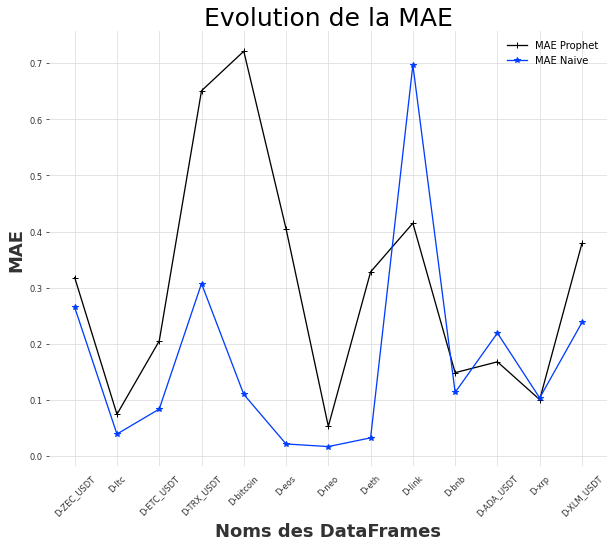

In [14]:
figure(figsize=(10, 8))
plt.axes()

liste_MAE1_prophet = results_prophet["MAE"].tolist()
liste_MAE_prophet = [float(item) for item in liste_MAE1_prophet]

liste_MAE1_naive = results_naive["MAE"].tolist()
liste_MAE_naive = [float(item) for item in liste_MAE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
y = np.array(liste_MAE_prophet)
y2 = np.array(liste_MAE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MAE Prophet', marker="+")
plt.plot(x, y2, label = 'MAE Naive', marker="*")
plt.title("Evolution de la MAE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MAE",fontsize=18)
plt.legend()
plt.show()

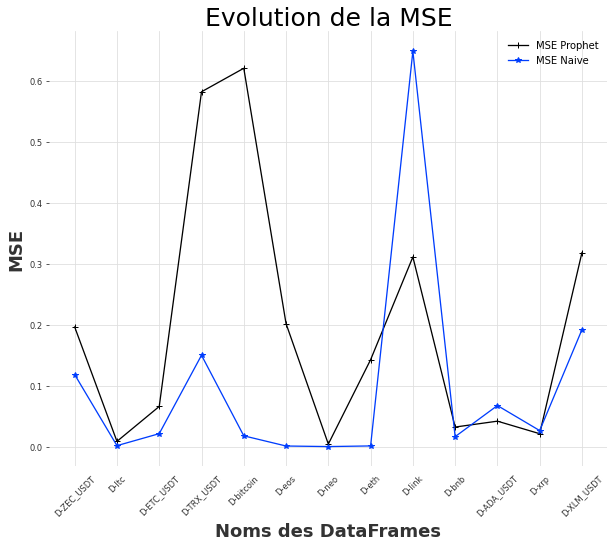

In [15]:
figure(figsize=(10, 8))
plt.axes()

liste_MSE1_prophet = results_prophet["MSE"].tolist()
liste_MSE_prophet = [float(item) for item in liste_MSE1_prophet]

liste_MSE1_naive = results_naive["MSE"].tolist()
liste_MSE_naive = [float(item) for item in liste_MSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
y = np.array(liste_MSE_prophet)
y2 = np.array(liste_MSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MSE Prophet', marker="+")
plt.plot(x, y2, label = 'MSE Naive', marker="*")
plt.title("Evolution de la MSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MSE",fontsize=18)
plt.legend()
plt.show()

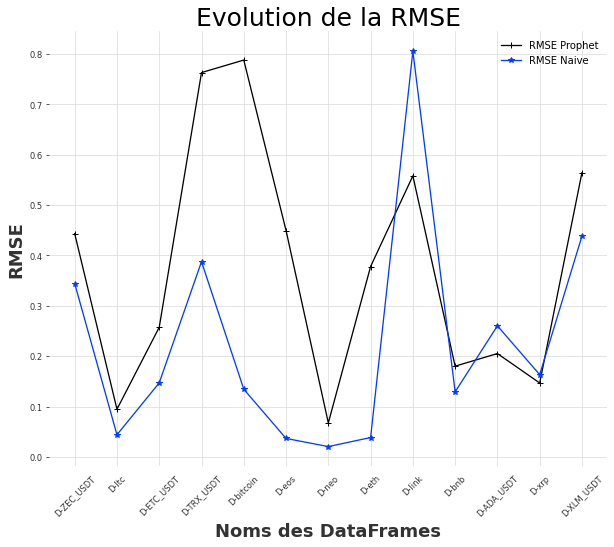

In [16]:
figure(figsize=(10, 8))
plt.axes()

liste_RMSE1_prophet = results_prophet["RMSE"].tolist()
liste_RMSE_prophet = [float(item) for item in liste_RMSE1_prophet]

liste_RMSE1_naive = results_naive["RMSE"].tolist()
liste_RMSE_naive = [float(item) for item in liste_RMSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
y = np.array(liste_RMSE_prophet)
y2 = np.array(liste_RMSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'RMSE Prophet', marker="+")
plt.plot(x, y2, label = 'RMSE Naive', marker="*")
plt.title("Evolution de la RMSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("RMSE",fontsize=18)
plt.legend()
plt.show()

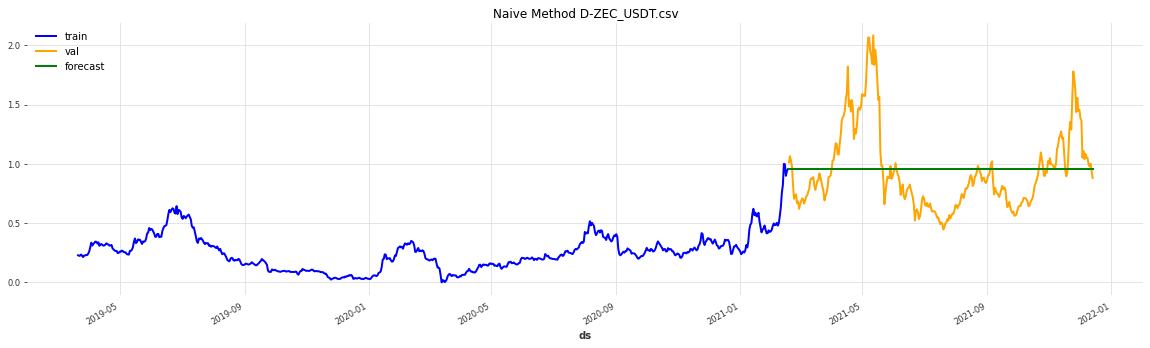

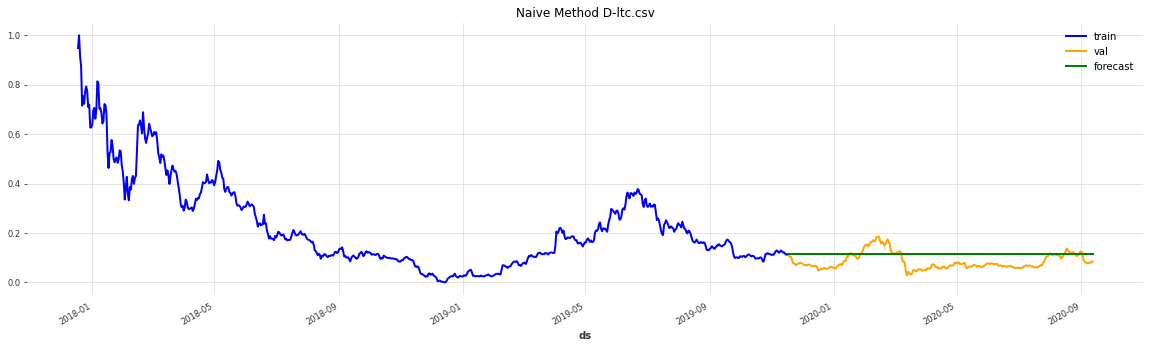

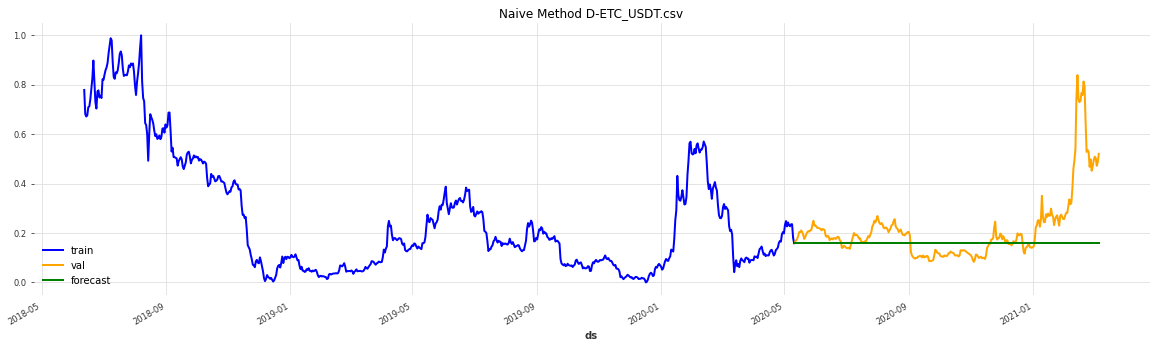

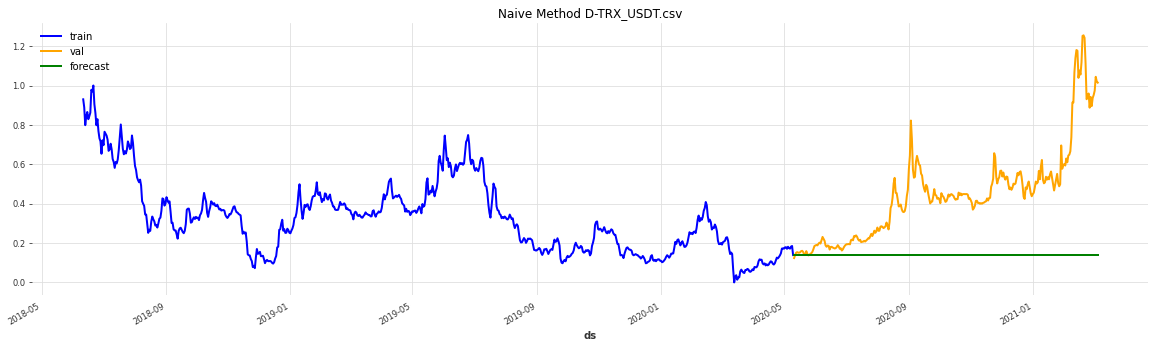

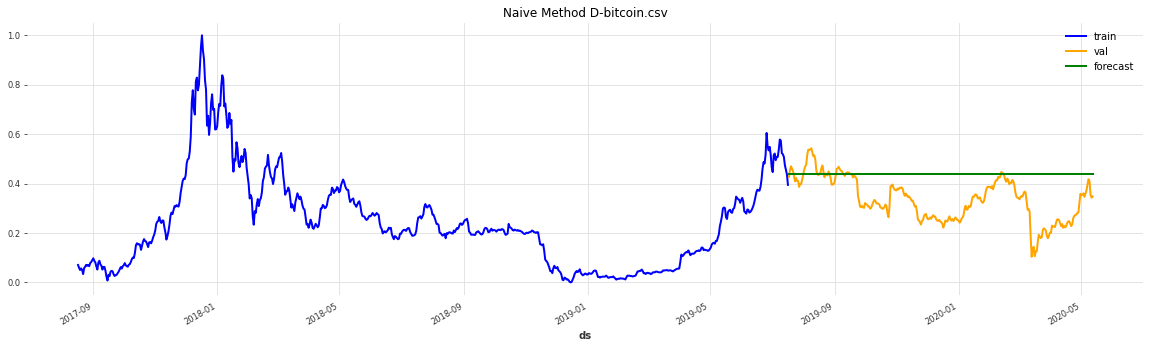

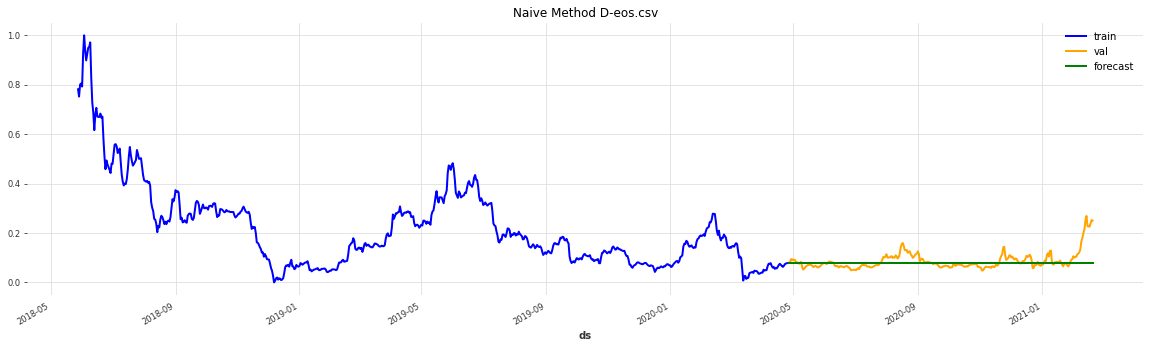

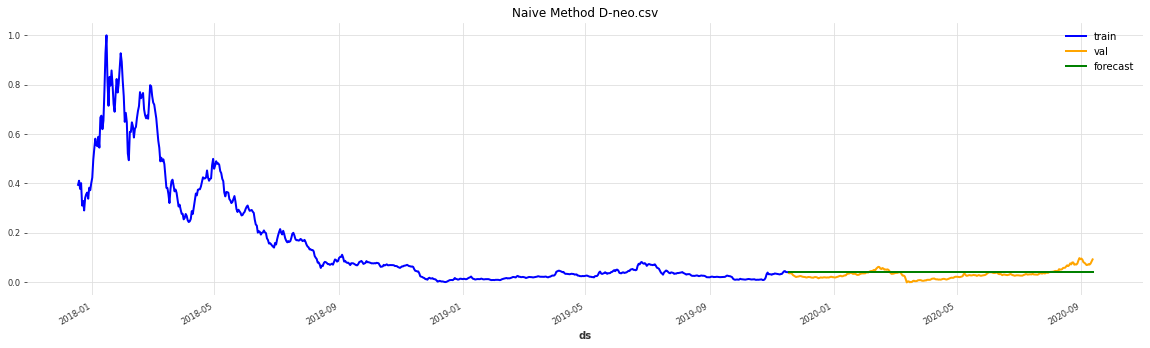

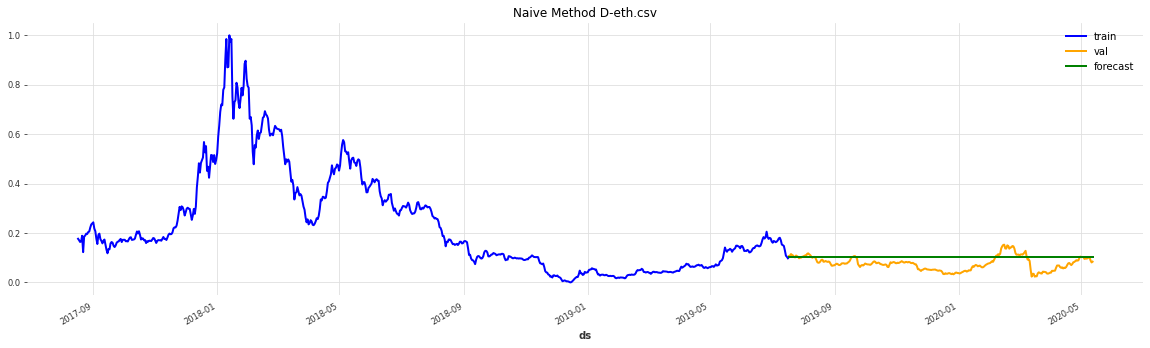

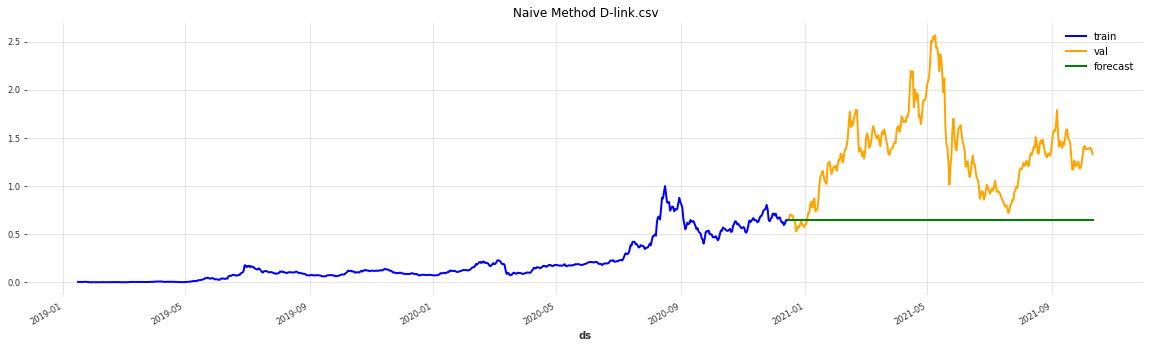

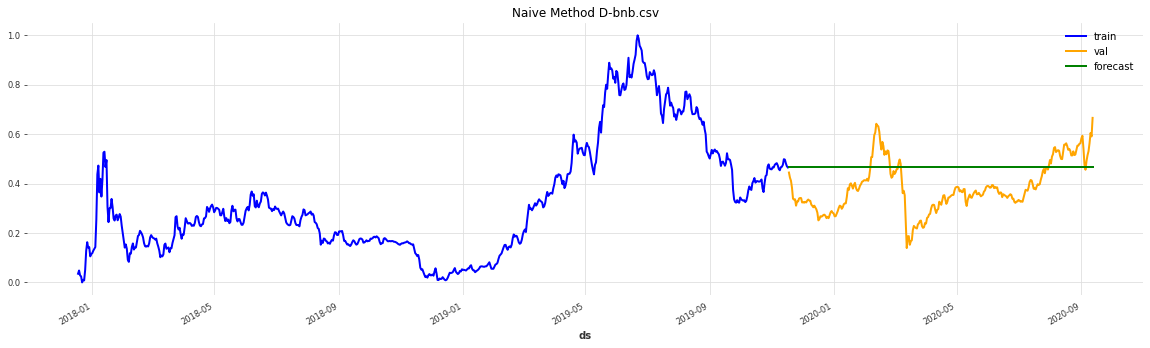

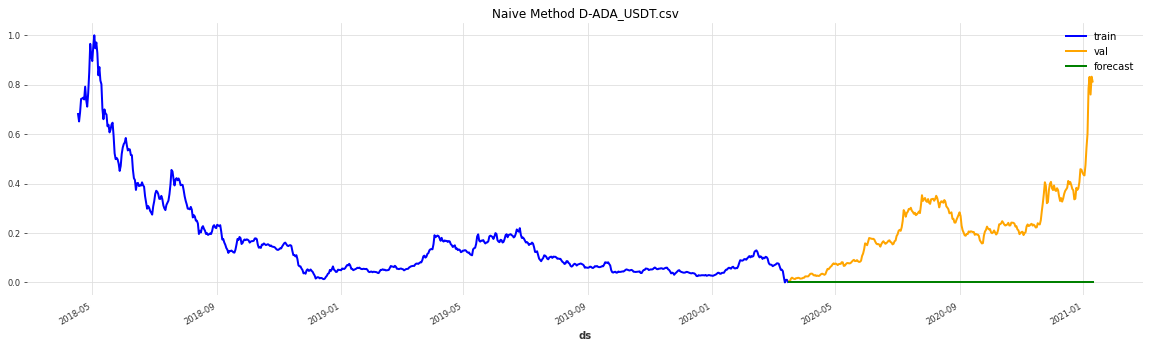

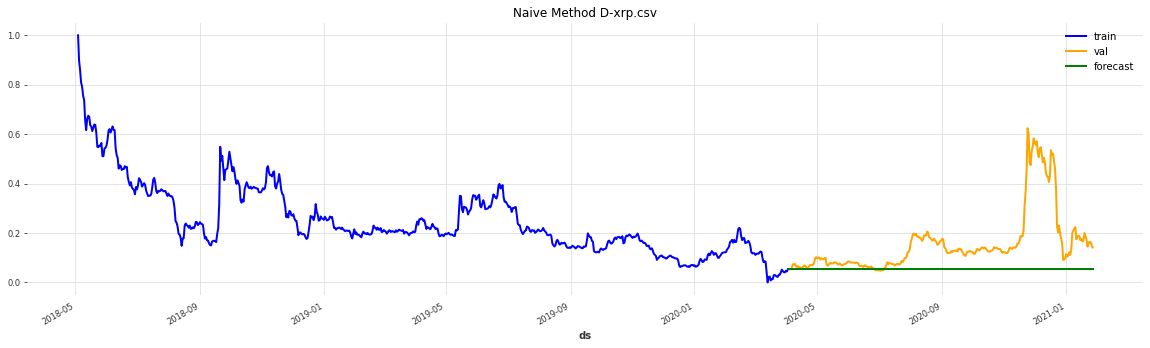

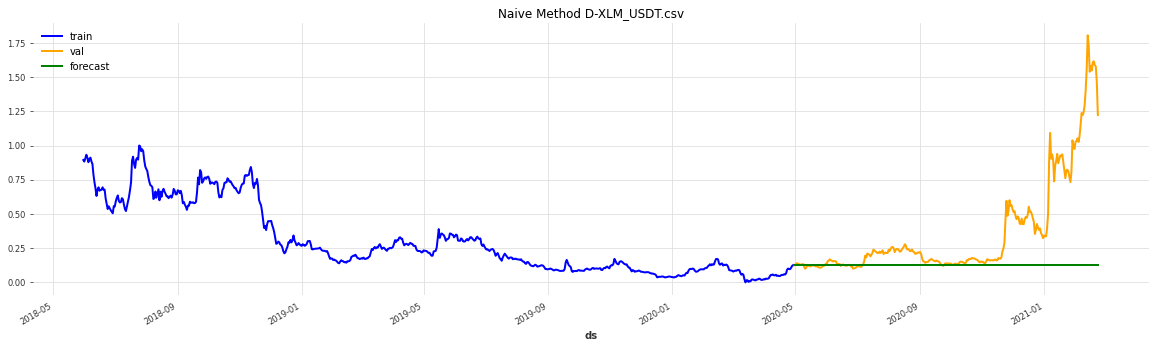

In [17]:
for i in range(len(df_fit_naive)):
    plt.figure(figsize=(20,5))
    df_fit_naive[i].plot(color ='blue', label="train")
    df_true_prediction_naive[i].plot(color ='orange', label="val")
    forecast_naive[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

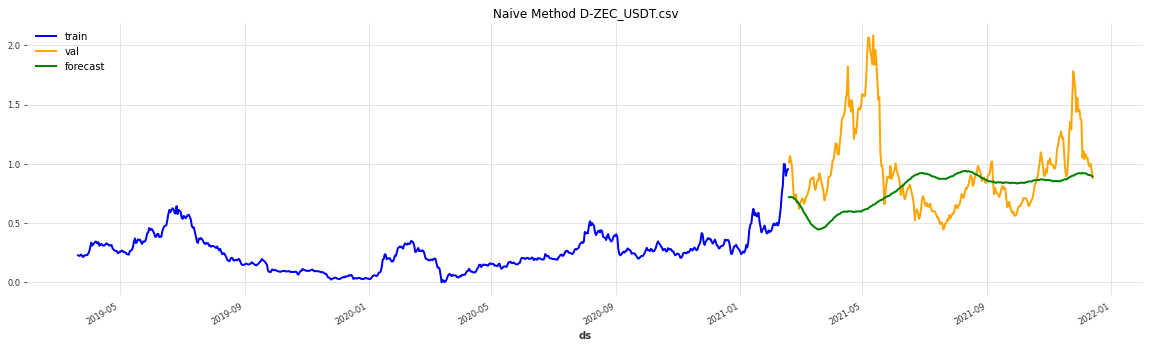

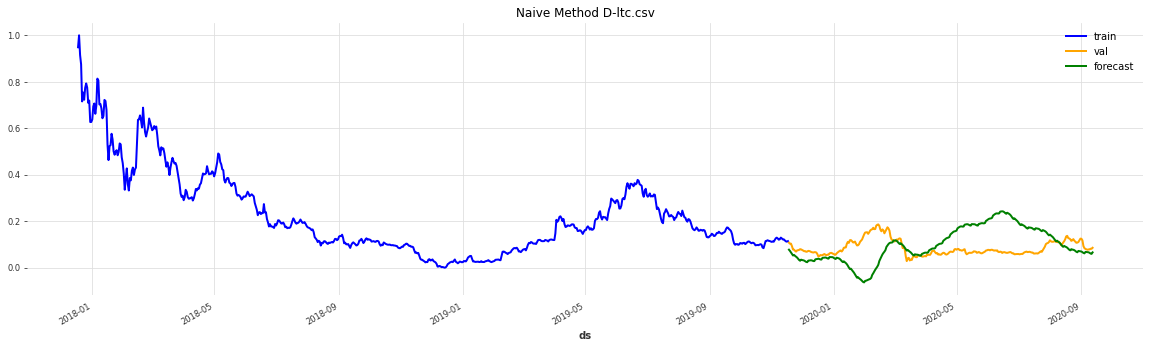

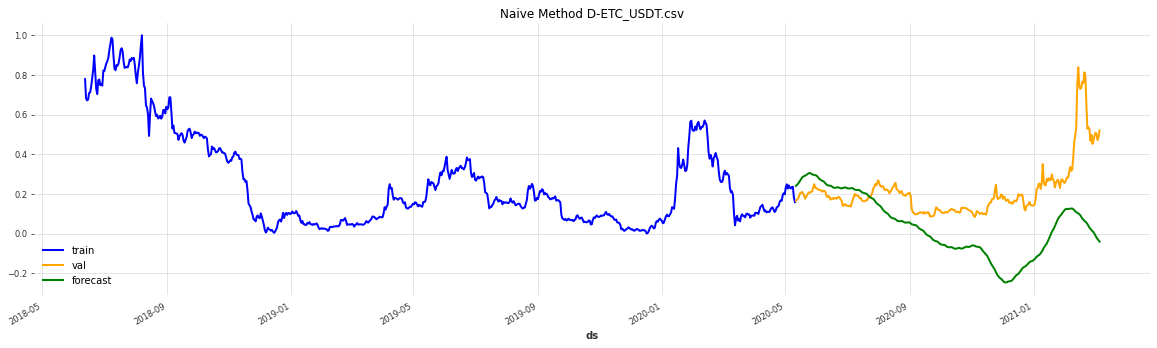

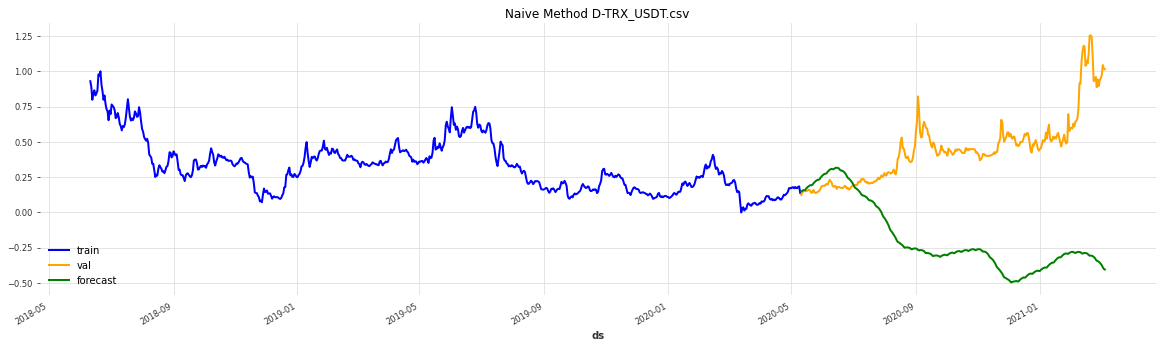

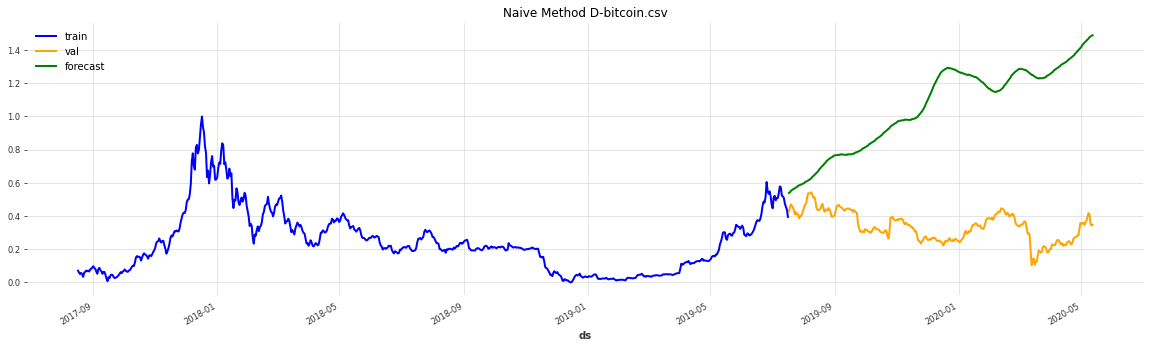

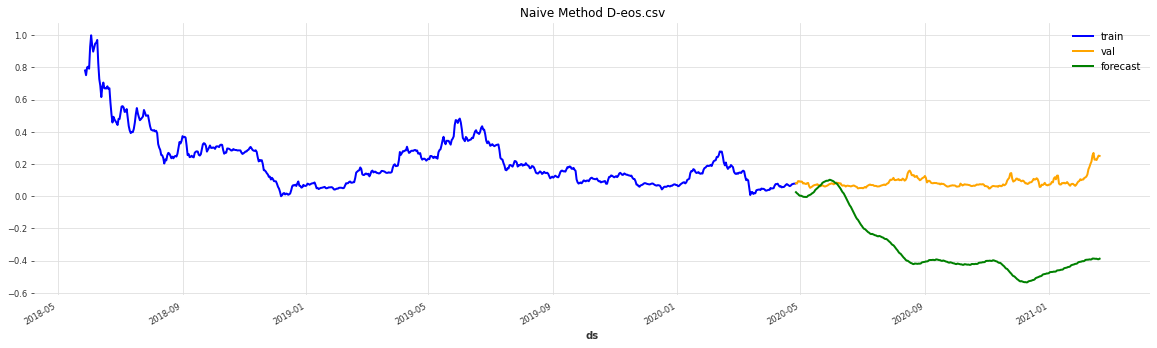

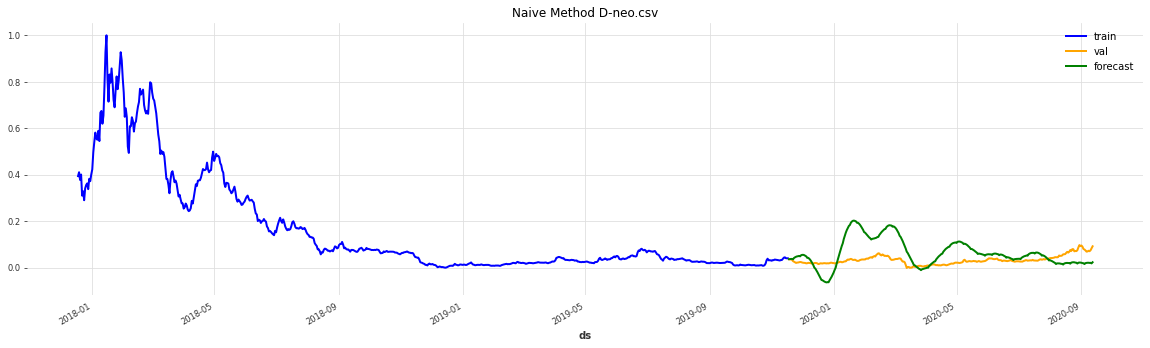

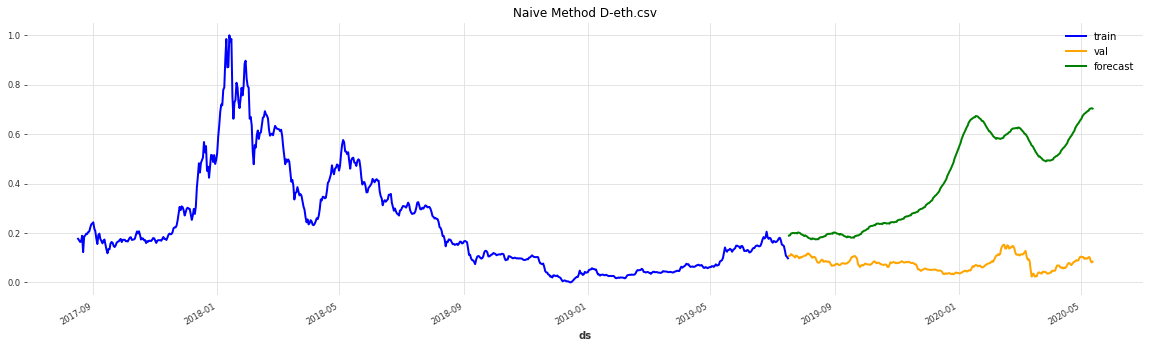

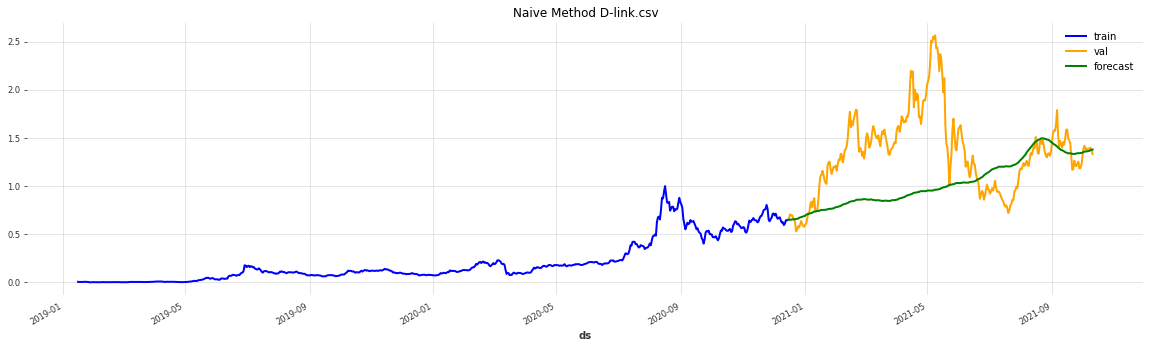

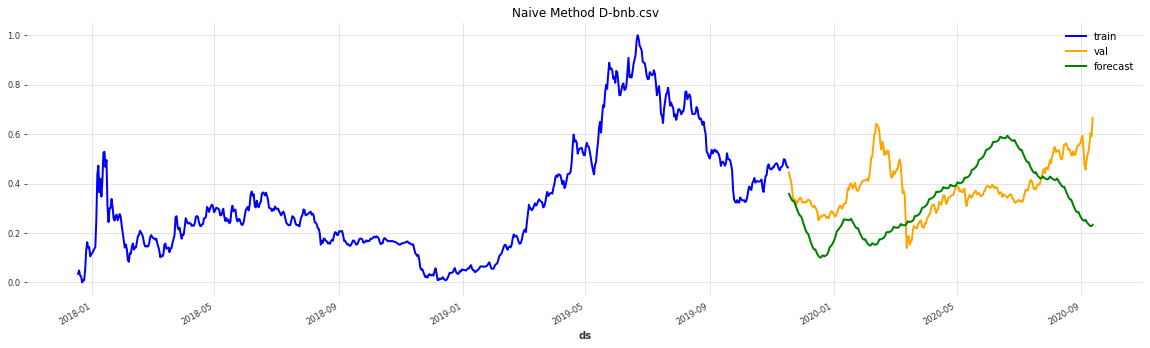

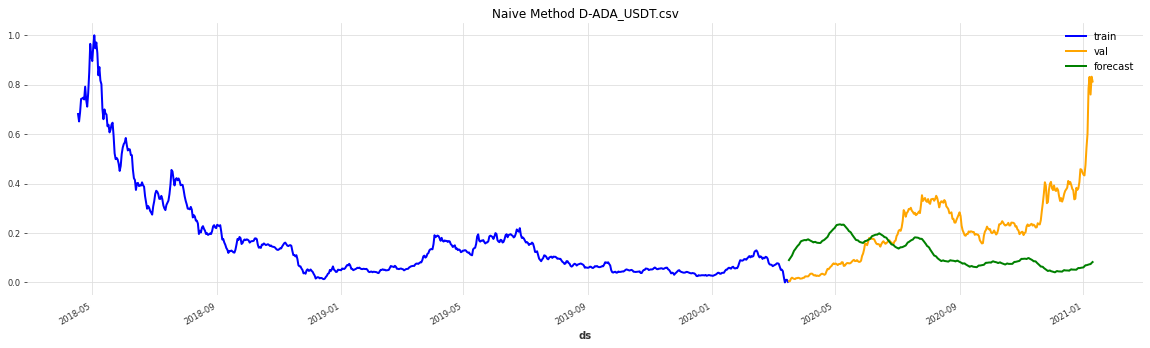

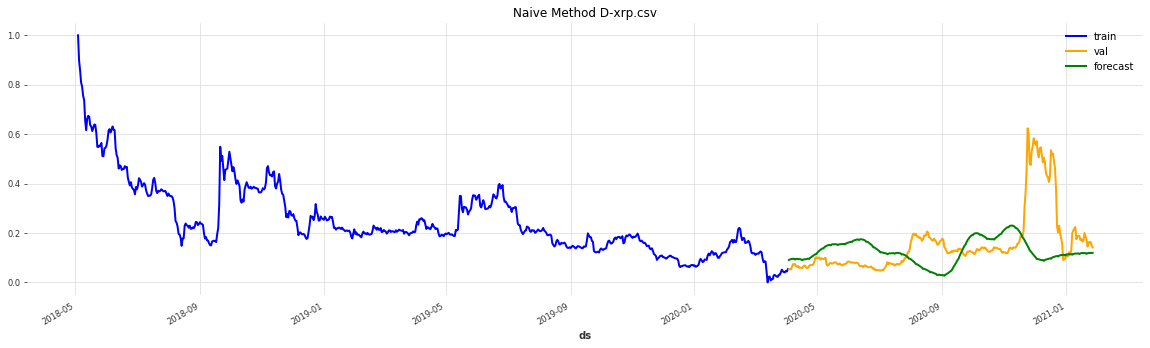

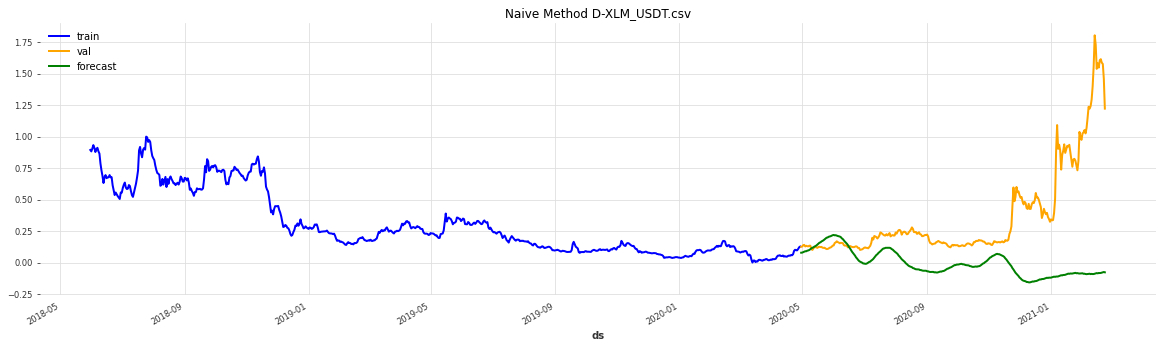

In [18]:
for i in range(len(df_fit_prophet)):
    plt.figure(figsize=(20,5))
    df_fit_prophet[i].plot(color ='blue', label="train")
    df_true_prediction_prophet[i].plot(color ='orange', label="val")
    forecast_prophet[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

In [19]:
for i in range(len(df_fit_naive)):
    if len(df_fit_naive[i]) != 700 :
        print("ERROR, len(df_fit_naive[{}]) = {}".format(i, len(df_fit_naive[i])))
    elif len(df_true_prediction_naive[i]) != 300 :
        print("ERROR, len(df_true_prediction_naive[{}]) = {}".format(i, len(df_true_prediction_naive[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----


In [20]:
for i in range(len(df_fit_prophet)):
    if len(df_fit_prophet[i]) != 700 :
        print("ERROR, len(df_fit_prophet[{}] = {}".format(i, len(df_fit_prophet[i])))
    elif len(df_true_prediction_prophet[i]) != 300 :
        print("ERROR, len(df_true_prediction_prophet[{}] = {}".format(i, len(df_true_prediction_prophet[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
